# Playground

* [Rescue those kittens!](#Rescue-those-kittens!)
* [Too much coffee with my hierarchical state machines!](#Too-much-coffee-with-my-hierarchical-state-machines!)
* [Very asynchronous dancing](#Very-asynchronous-dancing)
* [Fun with graphs](#Fun-with-graphs)


## Rescue those kittens!

In [ ]:
from transitions import Machine
import random

class NarcolepticSuperhero(object):

    # Define some states. Most of the time, narcoleptic superheroes are just like
    # everyone else. Except for...
    states = ['asleep', 'hanging out', 'hungry', 'sweaty', 'saving the world']
    # A more compact version of the quickstart transitions
    transitions = [['wakeup', 'asleep', 'hanging out'],
                   ['work_out',  'hanging out', 'hungry'],
                   ['eat', 'hungry', 'hanging out'],
                   {'trigger': 'distress_call', 'source': '*', 'dest':  'saving the world', 'before': 'change_into_super_secret_costume'},
                   {'trigger': 'complete_mission', 'source': 'saving the world', 'dest':  'sweaty', 'after': 'update_journal'},
                   {'trigger': 'clean_up', 'source': 'sweaty', 'dest':  'asleep', 'conditions': 'is_exhausted'},
                   ['clean_up', 'sweaty', 'hanging out'],
                   ['nap', '*', 'asleep']]


    def __init__(self, name):

        # No anonymous superheroes on my watch! Every narcoleptic superhero gets
        # a name. Any name at all. SleepyMan. SlumberGirl. You get the idea.
        self.name = name
        self.kittens_rescued = 0  # What have we accomplished today?

        # Initialize the state machine
        self.machine = Machine(model=self, states=NarcolepticSuperhero.states,
                               transitions=NarcolepticSuperhero.transitions, initial='asleep')

    def update_journal(self):
        """ Dear Diary, today I saved Mr. Whiskers. Again. """
        self.kittens_rescued += 1

    @property
    def is_exhausted(self):
        """ Basically a coin toss. """
        return random.random() < 0.5

    def change_into_super_secret_costume(self):
        print("Beauty, eh?")
        
batman = NarcolepticSuperhero("Batman")
batman.wakeup()
assert batman.state == 'hanging out'
#  the rest is up to you ...

## Too much coffee with my hierarchical state machines!

In [ ]:
from transitions.extensions import HierarchicalMachine as Machine

states = ['standing', 'walking', {'name': 'caffeinated', 'children':['dithering', 'running']}]
transitions = [
  ['walk', 'standing', 'walking'],
  ['stop', 'walking', 'standing'],
  ['drink', '*', 'caffeinated'],
  ['walk', ['caffeinated', 'caffeinated_dithering'], 'caffeinated_running'],
  ['relax', 'caffeinated', 'standing']
]

machine = Machine(states=states, transitions=transitions, initial='standing', ignore_invalid_triggers=True)

assert machine.walk() # Walking now
# I fancy a coffee right now ...

## Very asynchronous dancing

In [ ]:
from transitions.extensions.asyncio import AsyncMachine
import asyncio

class Dancer:
    
    states = ['start', 'left_food_left', 'left', 'right_food_right']
    
    def __init__(self, name, beat):
        self.my_name = name
        self.my_beat = beat
        self.moves_done = 0
        
    async def on_enter_start(self):
        self.moves_done += 1
        
    async def wait(self):
        print(f'{self.my_name} stepped {self.state}')
        await asyncio.sleep(self.my_beat)

    async def dance(self):
        while self.moves_done < 5:
            await self.step()
        
dancer1 = Dancer('Tick', 1)
dancer2 = Dancer('Tock', 1.1)

m = AsyncMachine(model=[dancer1, dancer2], states=Dancer.states, initial='start', after_state_change='wait')
m.add_ordered_transitions(trigger='step')

# it starts okay but becomes quite a mess
_ = await asyncio.gather(dancer1.dance(), dancer2.dance()) 

## Fun with graphs

This requires `pygraphviz` or `graphviz`

In [35]:
! pip install --user pygraphviz

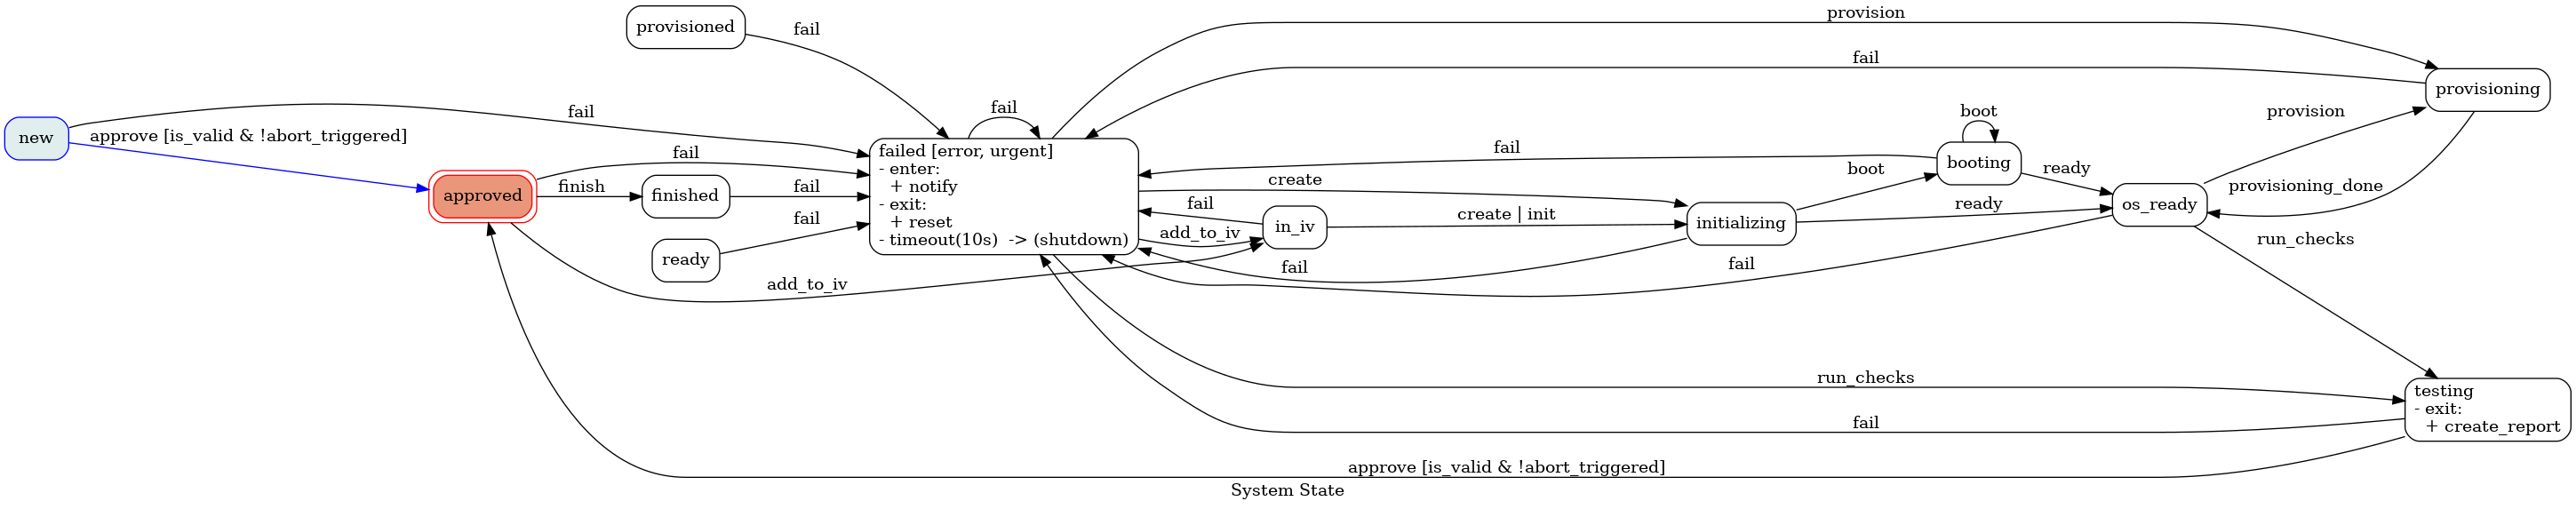

In [37]:
from transitions.extensions.states import Timeout, Tags, add_state_features
from transitions.extensions.diagrams import GraphMachine

import io
from IPython.display import Image, display, display_png


@add_state_features(Timeout, Tags)
class CustomMachine(GraphMachine):
    pass


states = ['new', 'approved', 'ready', 'finished', 'provisioned',
          {'name': 'failed', 'on_enter': 'notify', 'on_exit': 'reset',
           'tags': ['error', 'urgent'], 'timeout': 10, 'on_timeout': 'shutdown'},
          'in_iv', 'initializing', 'booting', 'os_ready', {'name': 'testing', 'on_exit': 'create_report'},
          'provisioning']

transitions = [{'trigger': 'approve', 'source': ['new', 'testing'], 'dest':'approved',
                'conditions': 'is_valid', 'unless': 'abort_triggered'},
               ['fail', '*', 'failed'],
               ['add_to_iv', ['approved', 'failed'], 'in_iv'],
               ['create', ['failed','in_iv'], 'initializing'],
               ['init', 'in_iv', 'initializing'],
               ['finish', 'approved', 'finished'],
               ['boot', ['booting', 'initializing'], 'booting'],
               ['ready', ['booting', 'initializing'], 'os_ready'],
               ['run_checks', ['failed', 'os_ready'], 'testing'],
               ['provision', ['os_ready', 'failed'], 'provisioning'],
               ['provisioning_done', 'provisioning', 'os_ready']]


class Model:
    
    # graph object is created by the machine
    def show_graph(self, **kwargs):
        stream = io.BytesIO()
        self.get_graph(**kwargs).draw(stream, prog='dot', format='png')
        display(Image(stream.getvalue()))
    
    def is_valid(self):
        return True
    
    def abort_triggered(self):
        return False

model = Model()
machine = CustomMachine(model=model, states=states, transitions=transitions, initial='new', title='System State',
                        show_conditions=True, show_state_attributes=True)
model.approve()
model.show_graph()

# Your turn! What happens next? 